In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

In [2]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

In [3]:
# Take Costco as an example to analysis
# Using data from 2015-10-01 to 2018-03-31 as training
# Using data from 2018-04-01 to 2018-10-01 as testing for the return
ticker = "COST"
start_date = '2015-10-01'
end_date = '2018-10-01'

In [4]:
stock_data = data.DataReader(ticker, 'iex', start_date, end_date)
print stock_data.shape
stock_data.head()

(756, 5)


,open,high,low,close,volume
date,,,,,
2015-10-01,134.5949,134.5949,132.4112,134.3254,2657336
2015-10-02,133.1081,135.5798,132.1232,135.5334,2591476
2015-10-05,135.8865,137.7216,135.6727,137.5869,2272955
2015-10-06,137.6612,138.1723,136.9272,137.9028,2127776
2015-10-07,138.1909,138.7484,136.9922,137.4847,2340843


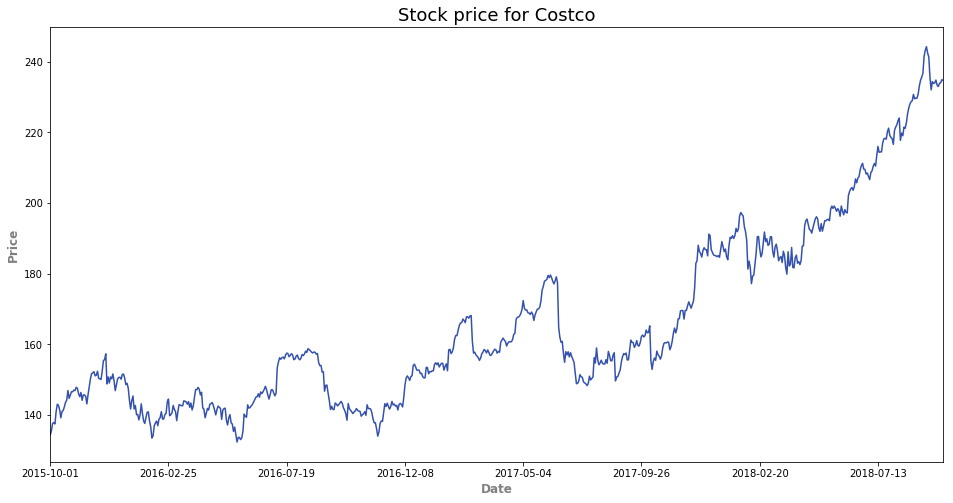

In [5]:
stock_data['close'].plot(figsize=(16,8),color='#002699',alpha=0.8)
plt.xlabel("Date",fontsize=12,fontweight='bold',color='gray')
plt.ylabel('Price',fontsize=12,fontweight='bold',color='gray')
plt.title("Stock price for Costco",fontsize=18)
plt.show()

In [6]:
def cycle_analysis(data,split_date,cycle,mode='additive',forecast_plot = False,print_ind=False):
    training = data[:split_date].iloc[:-1,]
    testing = data[split_date:]
    predict_period = len(pd.date_range(split_date,max(data.index)))
    df = training.reset_index()
    df.columns = ['ds','y']
    m = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
    m.add_seasonality('self_define_cycle',period=cycle,fourier_order=8,mode=mode)
    m.fit(df)
    future = m.make_future_dataframe(periods=predict_period)
    forecast = m.predict(future)
    if forecast_plot:
        m.plot(forecast)
        plt.plot(testing.index,testing.values,'.',color='#ff3333',alpha=0.6)
        plt.xlabel('Date',fontsize=12,fontweight='bold',color='gray')
        plt.ylabel('Price',fontsize=12,fontweight='bold',color='gray')
        plt.show()
    ret = max(forecast.self_define_cycle)-min(forecast.self_define_cycle)
    model_tb = forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x:x.strftime("%Y-%m-%d"))
    out_tb = pd.concat([testing,model_tb],axis=1)
    out_tb = out_tb[~out_tb.iloc[:,0].isnull()]
    out_tb = out_tb[~out_tb.iloc[:,1].isnull()]
    mse = mean_squared_error(out_tb.iloc[:,0],out_tb.iloc[:,1])
    rep = [ret,mse]
    if print_ind:
        print "Projected return per cycle: {}".format(round(rep[0],2))
        print "MSE: {}".format(round(rep[1],4))
    return rep

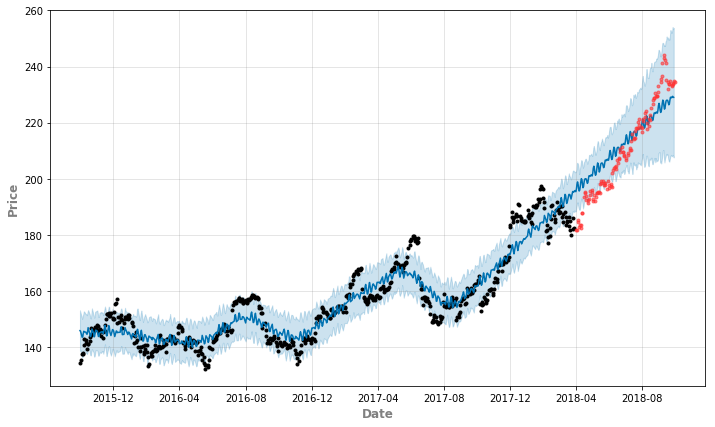

Projected return per cycle: 3.93
MSE: 60.4314


[3.93052965327124, 60.431382350806906]

In [7]:
cycle_analysis(stock_data['close'],'2018-04-01',30,forecast_plot=True,print_ind=True)

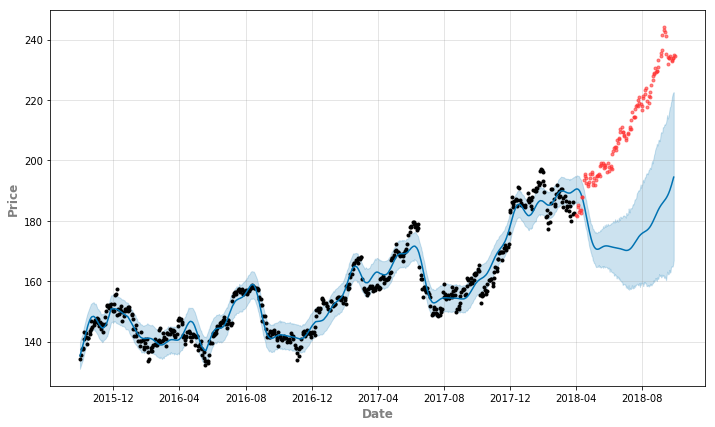

Projected return per cycle: 25.97
MSE: 1344.302


[25.97476173948787, 1344.3020168239323]

In [8]:
cycle_analysis(stock_data['close'],'2018-04-01',300,forecast_plot=True,print_ind=True)

In [9]:
testing_box = range(10,301)
return_box = []
mse_box = []
for c in testing_box:
    f = cycle_analysis(stock_data['close'],'2018-04-01',c)
    return_box.append(f[0])
    mse_box.append(f[1])

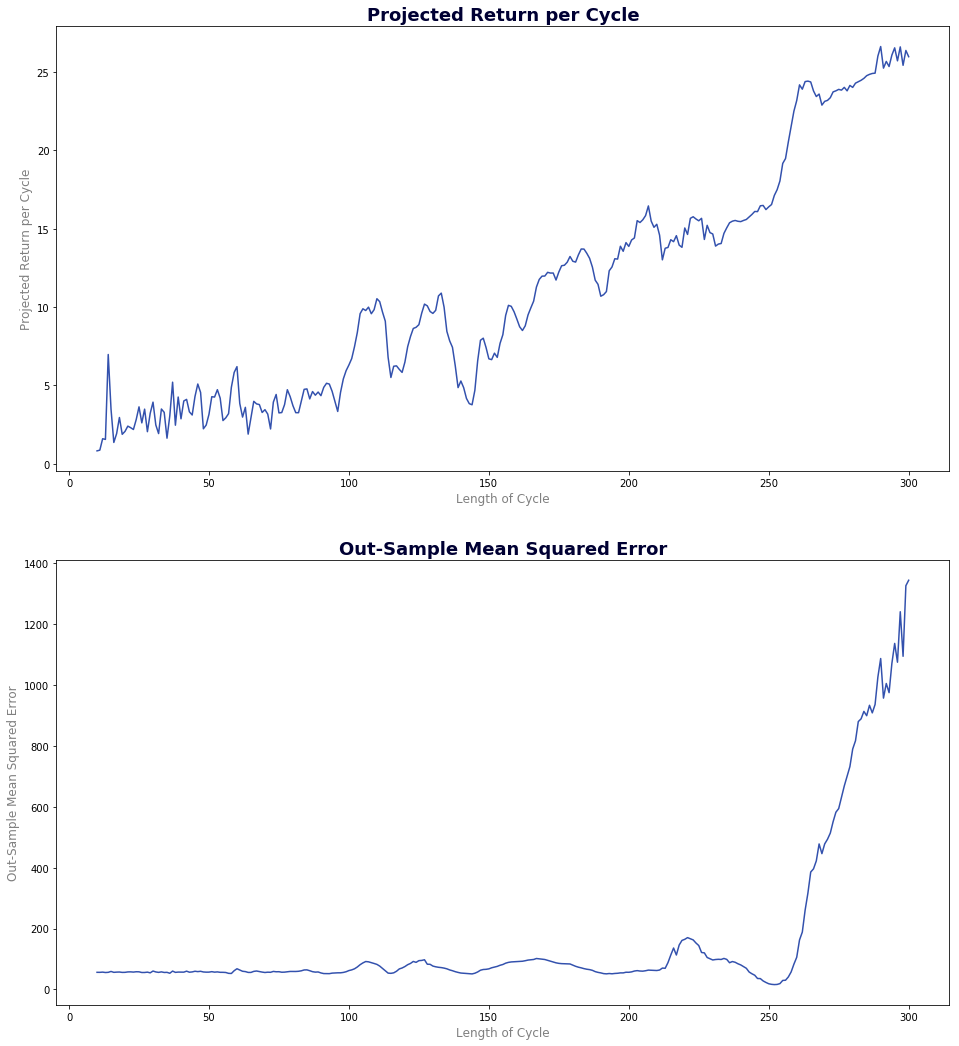

In [10]:
f = plt.figure(figsize=(16,18))
ax = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax.plot(testing_box,return_box,color='#002699',alpha=0.8)
ax2.plot(testing_box,mse_box,color='#002699',alpha=0.8)
ax.set_xlabel("Length of Cycle",fontsize=12,color='gray')
ax2.set_xlabel("Length of Cycle",fontsize=12,color='gray')
ax.set_ylabel("Projected Return per Cycle",fontsize=12,color='gray')
ax2.set_ylabel("Out-Sample Mean Squared Error",fontsize=12,color='gray')
ax.set_title("Projected Return per Cycle",fontsize=18,fontweight='bold',color='#000033')
ax2.set_title("Out-Sample Mean Squared Error",fontsize=18,fontweight='bold',color='#000033')
plt.show()

In [11]:
report = pd.DataFrame({'cycle':testing_box,'return':return_box,'mse':mse_box})
possible_choice = report[report['return'] >10]
possible_choice[possible_choice['mse']==min(possible_choice['mse'])]

,cycle,mse,return
242,252,15.93576,17.120216


In [12]:
c = possible_choice[possible_choice['mse']==min(possible_choice['mse'])]['cycle'].values[0]

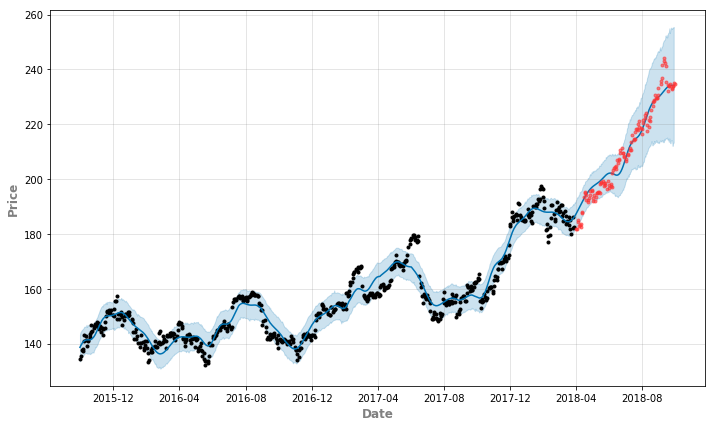

Projected return per cycle: 17.12
MSE: 15.9358


[17.120216439034987, 15.93576020351612]

In [13]:
cycle_analysis(stock_data['close'],'2018-04-01',c,forecast_plot=True,print_ind=True)

In [14]:
def Return_Dates(forecast,stock_data,cycle,cycle_name = 'self_define_cycle',time_name = 'ds'):
    # find out the highest and lowest dates in the first cycle 
    # We cannot simply search for all highest and lowest point since there is slightly difference for high and low values in different cycles
    high = forecast.iloc[:cycle,]
    high = high[high[cycle_name]==max(high[cycle_name])][time_name]
    high = datetime.strptime(str(high.values[0])[:10],"%Y-%m-%d")
    low = forecast.iloc[:cycle,]
    low = low[low[cycle_name]==min(low[cycle_name])][time_name]
    low = datetime.strptime(str(low.values[0])[:10],"%Y-%m-%d")
    end_dt = datetime.strptime(stock_data.index[-1],"%Y-%m-%d")
    find_list = stock_data.index.map(lambda x:datetime.strptime(x,"%Y-%m-%d"))
    # Finding selling and buying dates with loop
    sell_dt = []
    sell_dt.append(high)
    # Looking for new cycle until it goes beyond the last date in stock_data
    while high<end_dt:
        high = high+timedelta(days=cycle)
        dif = (find_list-high).days
        high = find_list[abs(dif)==min(abs(dif))][0] # In order to avoid the non-trading dates
        sell_dt.append(high)
    buy_dt = []
    buy_dt.append(low)
    # Looking for new cycle until it goes beyond the last date in stock_data
    while low<end_dt:
        low = low+timedelta(days=cycle)
        dif = (find_list-low).days
        low = find_list[abs(dif)==min(abs(dif))][0] # In order to avoid the non-trading dates
        buy_dt.append(low)
    if buy_dt[0] > sell_dt[0]:
        sell_dt = sell_dt[1:]
    buy_dt = buy_dt[:-1]
    sell_dt = sell_dt[:-1]
    return [buy_dt,sell_dt]

In [15]:
df = stock_data[:'2018-04-01'].iloc[:-1,]['close'].reset_index()
df.columns = ['ds','y']
predict_period = len(pd.date_range('2018-04-01','2018-10-01'))
m = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
m.add_seasonality('self_define_cycle',period=c,fourier_order=8,mode='additive')
m.fit(df)
future = m.make_future_dataframe(periods=predict_period)
forecast = m.predict(future)

In [16]:
dt_list = Return_Dates(forecast,stock_data,c)
buy_price = stock_data.loc[map(lambda x: x.strftime("%Y-%m-%d"),dt_list[0])]['close']
sell_price = stock_data.loc[map(lambda x: x.strftime("%Y-%m-%d"),dt_list[1])]['close']

In [17]:
buy_price

date
2016-02-26    139.8205
2016-11-04    134.0330
2017-07-14    150.8398
2018-03-23    179.8677
Name: close, dtype: float64

In [18]:
sell_price

date
2016-08-22    157.7646
2017-05-01    168.0492
2018-01-08    186.9662
2018-09-17    232.0000
Name: close, dtype: float64

In [23]:
# Setting for analysis
Analysis_ticks = ['COST','AAPL','MSFT','HD','NKE']
start_date = '2015-10-01'
end_date = '2018-10-01'
opt_cycle = []
prot_return = []
MSE = []
buy_times = []
sell_times = []
avg_buy_price = []
avg_sell_price = []
# Loop over each stock
for ticker in Analysis_ticks:
    stock_data = data.DataReader(ticker, 'iex', start_date, end_date)
    testing_box = range(50,301)
    return_box = []
    mse_box = []
    for cc in testing_box:
        f = cycle_analysis(stock_data['close'],'2018-04-01',cc)
        return_box.append(f[0])
        mse_box.append(f[1])
    report = pd.DataFrame({'cycle':testing_box,'return':return_box,'mse':mse_box})
    possible_choice = report[report['return'] >10]
    # If we cannot find a cycle with return greater than 10, give 0
    if possible_choice.shape[0]>0:
        c = possible_choice[possible_choice['mse']==min(possible_choice['mse'])]['cycle'].values[0]
        rp = possible_choice[possible_choice['mse']==min(possible_choice['mse'])]['return'].values[0]
        mse = possible_choice[possible_choice['mse']==min(possible_choice['mse'])]['mse'].values[0]
        df = stock_data[:'2018-04-01'].iloc[:-1,]['close'].reset_index()
        df.columns = ['ds','y']
        predict_period = len(pd.date_range('2018-04-01','2018-10-01'))
        m = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
        m.add_seasonality('self_define_cycle',period=c,fourier_order=8,mode='additive')
        m.fit(df)
        future = m.make_future_dataframe(periods=predict_period)
        forecast = m.predict(future)
        dt_list = Return_Dates(forecast,stock_data,c)
        buy_price = stock_data.loc[map(lambda x: x.strftime("%Y-%m-%d"),dt_list[0])]['close']
        sell_price = stock_data.loc[map(lambda x: x.strftime("%Y-%m-%d"),dt_list[1])]['close']
        bt = buy_price.shape[0]
        st = sell_price.shape[0]
        bp = np.mean(buy_price)
        sp = np.mean(sell_price)
    else:
        c = 0
        rp = 0
        mse = 0
        bt = 0
        st = 0
        bp = 0
        sp = 0
    opt_cycle.append(c)
    prot_return.append(rp)
    MSE.append(mse)
    buy_times.append(bt)
    sell_times.append(st)
    avg_buy_price.append(bp)
    avg_sell_price.append(sp)
    print "{} Finished".format(ticker)

COST Finished
AAPL Finished
MSFT Finished
HD Finished
NKE Finished


In [24]:
stock_report = pd.DataFrame({'Stock':Analysis_ticks,'Cycle':opt_cycle,'Projected_Return_per_Cycle':prot_return,
                            'MSE':MSE,'Num_of_Buy':buy_times,'Num_of_Sell':sell_times,
                            'Average_Buy_Price':avg_buy_price,'Average_Sell_Price':avg_sell_price})
stock_report

,Average_Buy_Price,Average_Sell_Price,Cycle,MSE,Num_of_Buy,Num_of_Sell,Projected_Return_per_Cycle,Stock
0,151.140250,186.195000,252,15.935760,4,4,17.120216,COST
1,137.180750,155.249000,253,210.800365,4,4,11.678807,AAPL
2,0.000000,0.000000,0,0.000000,0,0,0.000000,MSFT
3,135.516975,160.886133,263,31.108088,4,3,26.833305,HD
4,0.000000,0.000000,0,0.000000,0,0,0.000000,NKE


In [25]:
stock_report.to_csv('Stock_Report.csv',index=False)